
# DBbun EEG — Validation & Preview Notebook

This notebook computes **descriptive realism metrics** for the DBbun Synthetic EEG dataset and creates small **preview plots** for visual inspection.

> **Notes**  
> - The notebook reports descriptive statistics (e.g., bandpower ratios, durations, seizure fraction) and saves a concise `realism_report.md`.  
> - It also exports a few PNG previews per split for the Hugging Face repo.


In [1]:

# Configure paths (edit if needed)
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Root where your split folders live (train/ valid/ test/)
DATA_ROOT = Path(r"D:/dbbun-eeg/data")  # Change if needed, e.g., Path("dbbun-eeg/data")

PREVIEWS_DIR = DATA_ROOT.parent.parent / "previews"
VALIDATION_DIR = DATA_ROOT.parent.parent / "validation"
PREVIEWS_DIR.mkdir(parents=True, exist_ok=True)
VALIDATION_DIR.mkdir(parents=True, exist_ok=True)

print("Using DATA_ROOT =", DATA_ROOT)
print("Previews ->", PREVIEWS_DIR)
print("Validation ->", VALIDATION_DIR)


Using DATA_ROOT = D:\dbbun-eeg\data
Previews -> D:\previews
Validation -> D:\validation


In [2]:

def bandpower_windows(x, fs, f1, f2):
    """Compute mean bandpower between f1..f2 for each window (last axis is samples).
    Supports input shaped [channels, windows, samples] or [windows, samples].
    """
    X = np.asarray(x)
    if X.ndim == 3:
        T = X.shape[-1]
        freqs = np.fft.rfftfreq(T, 1/fs)
        psd = (np.abs(np.fft.rfft(X, axis=-1))**2)/T
        mask = (freqs >= f1) & (freqs < f2)
        return psd[..., mask].mean(axis=-1)
    elif X.ndim == 2:
        T = X.shape[-1]
        freqs = np.fft.rfftfreq(T, 1/fs)
        psd = (np.abs(np.fft.rfft(X, axis=-1))**2)/T
        mask = (freqs >= f1) & (freqs < f2)
        return psd[:, mask].mean(axis=-1)
    else:
        raise ValueError("Unsupported input shape for bandpower_windows")
        
def summarize_split(split_dir, fs=250, win_s=4, max_files=12):
    """Scan NPZs, compute descriptive metrics, write preview PNGs, and return a DataFrame."""
    D = Path(split_dir)
    rows = []
    made = 0
    for npz_path in sorted(D.glob("*.npz")):
        try:
            z = np.load(npz_path)
        except Exception as e:
            print("Skip (load error):", npz_path, e)
            continue
        eeg = z["eeg"]
        sr = int(z["sr"])
        chans = [c.decode() if isinstance(c, bytes) else c for c in z["channels"]]
        labels = z["labels_sec"]
        ch, n = eeg.shape
        w = win_s * fs
        nwin = n // w
        if nwin == 0:
            continue
        X = eeg[:, :nwin*w].reshape(ch, nwin, w)
        a = bandpower_windows(X, fs, 8, 13)
        b = bandpower_windows(X, fs, 14, 25)
        d = bandpower_windows(X, fs, 1, 4)
        denom = (a + b + d + 1e-12)
        alpha_ratio = (a / denom).mean()
        delta_ratio = (d / denom).mean()
        seizure_frac = float(labels.mean()) if labels.size > 0 else 0.0
        rows.append(dict(
            file=npz_path.name,
            alpha_ratio=float(alpha_ratio),
            delta_ratio=float(delta_ratio),
            n_channels=int(ch),
            seconds=int(n // fs),
            seizure_frac=seizure_frac
        ))
        if made < max_files:
            ch_idx = chans.index("Cz") if "Cz" in chans else 0
            T = min(10*sr, n)
            fig, ax = plt.subplots(figsize=(6, 1.6))
            ax.plot(np.arange(T)/sr, eeg[ch_idx, :T])
            ax.set_xlabel("s")
            ax.set_ylabel("V")
            ax.set_title(npz_path.name)
            fig.tight_layout()
            out_png = PREVIEWS_DIR / f"{npz_path.stem}_preview.png"
            fig.savefig(out_png, dpi=120)
            plt.close(fig)
            made += 1
    return pd.DataFrame(rows)


In [3]:

all_tables = []
for split in ["train", "valid", "test"]:
    split_path = DATA_ROOT / split
    if not split_path.exists():
        print(f"[WARN] Missing split: {split_path}")
        continue
    print(f"Scanning {split_path} ...")
    df = summarize_split(split_path, fs=250, win_s=4, max_files=12)
    if not df.empty:
        desc = df.describe().round(6)
        display(desc)
        (VALIDATION_DIR / f"{split}_summary.md").write_text(desc.to_markdown(index=True))
        df['split'] = split
        all_tables.append(df)
    else:
        print(f"[WARN] No NPZ files in: {split_path}")
        
if all_tables:
    combo = pd.concat(all_tables, ignore_index=True)
    combo_desc = combo.groupby('split')[['alpha_ratio','delta_ratio','n_channels','seconds','seizure_frac']].describe().round(6)
    display(combo_desc)
    (VALIDATION_DIR / "realism_report.md").write_text(combo_desc.to_markdown())
    print("Saved combined report to:", VALIDATION_DIR / "realism_report.md")
else:
    print("No data found; adjust DATA_ROOT and re-run.")


Scanning D:\dbbun-eeg\data\train ...


alpha_ratio  delta_ratio  n_channels      seconds  seizure_frac
count   200.000000   200.000000       200.0   200.000000    200.000000
mean      0.502662     0.421195        38.0  3581.180000      0.010507
std       0.017428     0.016434         0.0   620.469945      0.011507
min       0.457906     0.363766        38.0  1782.000000      0.000000
25%       0.491940     0.411584        38.0  3123.000000      0.000000
50%       0.502194     0.421502        38.0  3669.500000      0.007949
75%       0.514187     0.433438        38.0  3979.500000      0.017142
max       0.560586     0.454768        38.0  5063.000000      0.082060

Scanning D:\dbbun-eeg\data\valid ...


alpha_ratio  delta_ratio  n_channels      seconds  seizure_frac
count    25.000000    25.000000        25.0    25.000000     25.000000
mean      0.503105     0.420386        38.0  3527.240000      0.011342
std       0.015542     0.015221         0.0   592.338324      0.010930
min       0.481272     0.388402        38.0  2300.000000      0.000000
25%       0.491868     0.413763        38.0  3227.000000      0.000000
50%       0.499719     0.423314        38.0  3641.000000      0.010887
75%       0.509000     0.428094        38.0  3791.000000      0.018021
max       0.538525     0.445576        38.0  4995.000000      0.034643

Scanning D:\dbbun-eeg\data\test ...


alpha_ratio  delta_ratio  n_channels     seconds  seizure_frac
count    25.000000    25.000000        25.0    25.00000     25.000000
mean      0.503643     0.421051        38.0  3539.20000      0.014401
std       0.018605     0.018991         0.0   628.96436      0.014606
min       0.452780     0.377042        38.0  2321.00000      0.000000
25%       0.495683     0.412317        38.0  2950.00000      0.000000
50%       0.503668     0.422443        38.0  3647.00000      0.011587
75%       0.514700     0.430467        38.0  4011.00000      0.020816
max       0.538062     0.467878        38.0  4708.00000      0.050545

alpha_ratio                                                              \
            count      mean       std       min       25%       50%       75%   
split                                                                           
test         25.0  0.503643  0.018605  0.452780  0.495683  0.503668  0.514700   
train       200.0  0.502662  0.017428  0.457906  0.491940  0.502194  0.514187   
valid        25.0  0.503105  0.015542  0.481272  0.491868  0.499719  0.509000   

                delta_ratio            ... seconds         seizure_frac  \
            max       count      mean  ...     75%     max        count   
split                                  ...                                
test   0.538062        25.0  0.421051  ...  4011.0  4708.0         25.0   
train  0.560586       200.0  0.421195  ...  3979.5  5063.0        200.0   
valid  0.538525        25.0  0.420386  ...  3791.0  4995.0         25.0   

                                                                   
           mean       std  min  25%       50%       75%       max  
split                                                              
test   0.014401  0.014606  0.0  0.0  0.011587  0.020816  0.050545  
train  0.010507  0.011507  0.0  0.0  0.007949  0.017142  0.082060  
valid  0.011342  0.010930  0.0  0.0  0.010887  0.018021  0.034643  

[3 rows x 40 columns]

Saved combined report to: D:\validation\realism_report.md



## Preview Gallery

The previews saved in the `previews/` directory can be displayed inline below.


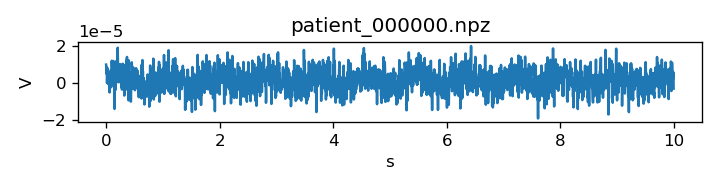

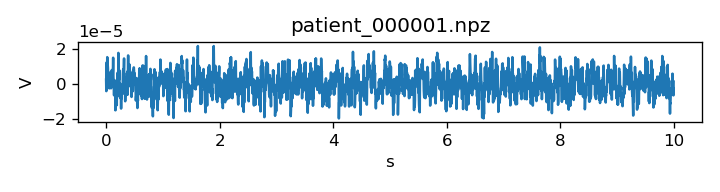

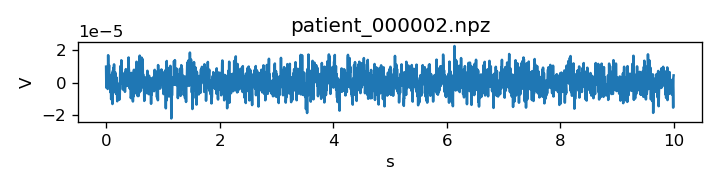

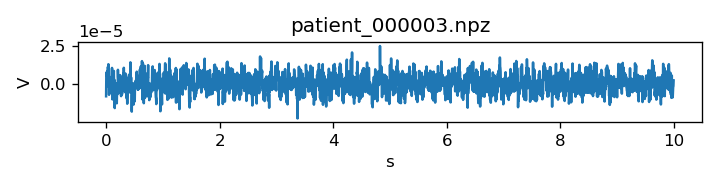

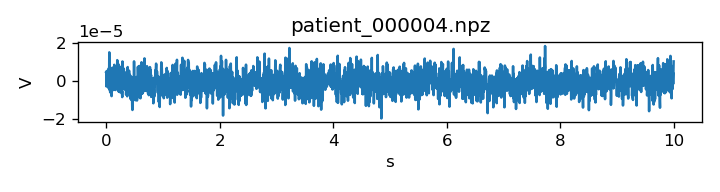

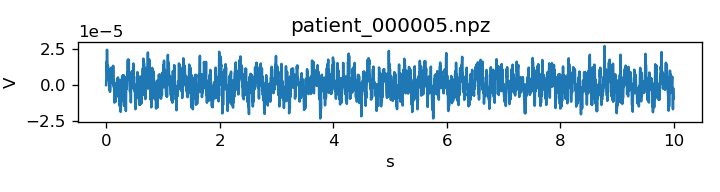

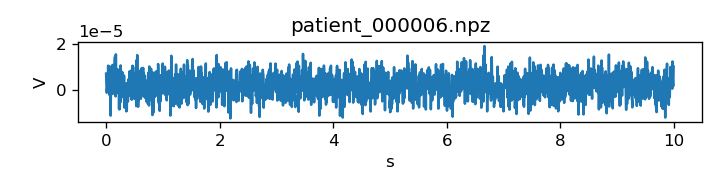

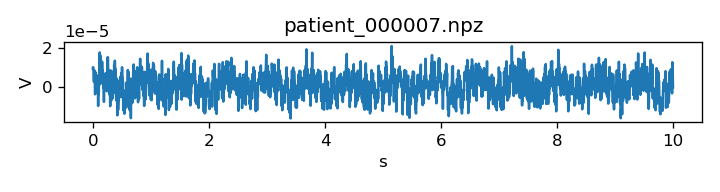

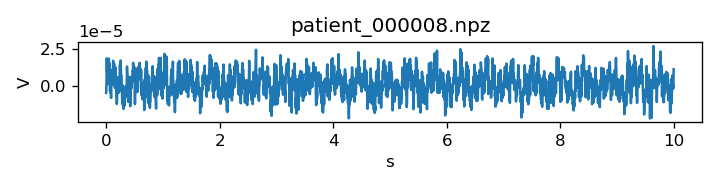

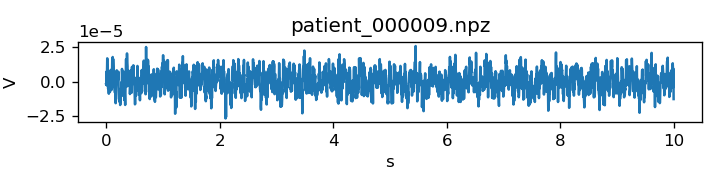

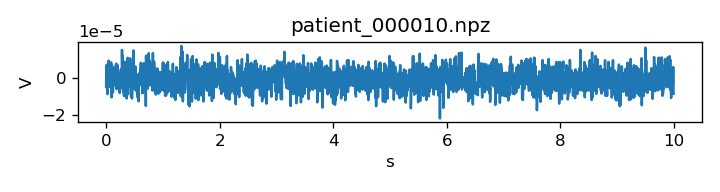

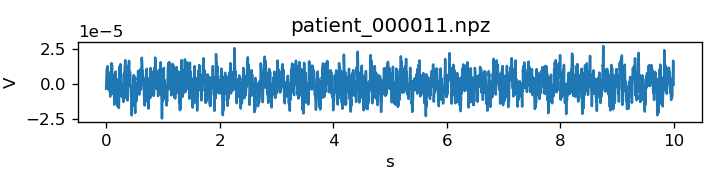

In [4]:

from IPython.display import display, Image
pngs = sorted(PREVIEWS_DIR.glob("*_preview.png"))[:12]
for p in pngs:
    display(Image(filename=str(p)))
